## Utilização de Séries Temporais para previsão do valor de ações

**Descrição do Problema** - Prever de forma acurada o comportamento do mercado de ações é uma tarefa complexa. Para avaliar o comportamento de uma ação podem ser utilizadas técnicas que comparam a influência de fatores externos no desempenho da empresa, entre esses fatores temos a situação de seus competidores, o cenário econômico, fiscal e geopolítico em determinado momento. Além dos fatores externos podemos considerar também a situação da própria empresa, entre esses fatores temos o índice de liquidez, o índice de endividamento e o lucro por ação. Uma outra técnica bastante utilizada são os indicadores técnicos. Um indicador técnico é um instrumento matemático que auxilia a entender a movimento do preço de uma ação. O indicador é a representação gráfica de uma fórmula utilizada na geração do preço. A facilidade da representação gráfica desses índices facilita o entendimento do mercado. Entre os indicadores mais utilizados temos as médias móveis simples, médias móveis exponenciais e bandas de Bollinger.
O trabalho irá fazer a previsão dos movimentos de preço da Petrobras (PETR4). Para isso iremos usar o preço de fechamento diário. O preço previsto será baseado no preço de fechamento dos cinco dias anteriores. Para a previsão do preço de fechamento serão usados os modelos de rede neural RNN, LSTM (um tipo de RNN) e GRU. Será feita uma avaliação da efetividade de cada rede neural na previsão.

**Dataset** - O dataset PETR4.SA contém dados históricos do valor de ações da empresa Petróleo Brasileiro SA (Petrobras).

### Importação de bibliotecas

In [1]:
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import option_context
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from matplotlib import pyplot
%matplotlib inline

### Funções utilitárias

In [2]:
def exibe_dataset(dados, linhas): 
    with option_context('display.max_rows',linhas*2):
        display(dados)

In [3]:
def converte_serie(dados, num_in, num_out):
    colunas, nomes = list(), list()

    num_vars = 1 if type(dados) is list else dados.shape[1]
    df = DataFrame(dados)

    for i in range(num_in, 0, -1):
        colunas.append(df.shift(i))
        nomes += [('x%d(t-%d)' % (j+1, i)) for j in range(num_vars)]

    for i in range(0, num_out):
        colunas.append(df.shift(-i))
        if i == 0:
            nomes += [('x%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            nomes += [('x%d(t+%d)' % (j+1, i)) for j in range(num_vars)]

    serie = concat(colunas, axis=1)
    serie.columns = nomes
    serie.dropna(inplace=True)
    
    return serie

In [4]:
def cria_dataset_treino_teste(ds_nova_escala, num_time_frames):
    num_time_frames_aux = num_time_frames
    num_features_aux = ds_nova_escala.shape[1]
    num_obs_aux = num_time_frames_aux * num_features_aux

    ds_convertido = converte_serie(ds_nova_escala, num_time_frames_aux, 1)

    m = []
    for i in range(num_features_aux+1,num_features_aux*2):
        m.append(i)

    ds_convertido.drop(ds_convertido.columns[m], axis=1, inplace=True)

    ds_valor = ds_convertido.values

    tam = int(len(ds_valor) * 0.66)

    ds_treino = ds_valor[:tam, :]
    ds_teste = ds_valor[tam:, :]
    ds_treino_tam = len(ds_treino)
    ds_teste_tam = len(ds_teste)

    X_treino_aux, y_treino_aux = ds_treino[:, :(-1 if num_time_frames_aux == 1 else num_obs_aux)], ds_treino[:, -num_features_aux]
    X_teste_aux, y_teste_aux = ds_teste[:, :(-1 if num_time_frames_aux == 1 else num_obs_aux)], ds_teste[:, -num_features_aux]

    X_treino_aux = X_treino_aux.reshape((X_treino_aux.shape[0], num_time_frames_aux, (X_treino_aux.shape[1] if num_time_frames_aux == 1 else num_features_aux)))
    X_teste_aux = X_teste_aux.reshape((X_teste_aux.shape[0], num_time_frames_aux, (X_teste_aux.shape[1] if num_time_frames_aux == 1 else num_features_aux)))

    return X_treino_aux, y_treino_aux, X_teste_aux, y_teste_aux, num_time_frames_aux, num_features_aux, num_obs_aux

In [5]:
def exibe_resultados(historico, teste_inv, previsao_inv, label_loss, label_previsao, label_mse):
    pyplot.figure(figsize=(15, 4), dpi=100)

    #pyplot.subplot(2, 1, 1)
    pyplot.subplot(1, 2, 1)
    pyplot.plot(historico.history['loss'], label='Treino', color='tab:green')
    pyplot.plot(historico.history['val_loss'], label='Teste', color='tab:pink')
    pyplot.title(label_loss)
    pyplot.ylabel('Loss')
    pyplot.xlabel('Épocas')
    pyplot.legend()

    #pyplot.subplot(2, 1, 2)
    pyplot.subplot(1, 2, 2)
    pyplot.plot(teste_inv, label='Fechamento', color='b')
    pyplot.plot(previsao_inv, label='Previsão', color='tab:orange')
    pyplot.title(label_previsao)
    pyplot.ylabel('R$')
    pyplot.legend()

    pyplot.show()

    mse = mean_squared_error(teste_inv, previsao_inv)
    print(label_mse + ' %.3f' % mse)   

In [6]:
def processa_modelo(tipo, X_treino, y_treino, X_teste, y_teste, num_time_frames, num_obs, num_features):
    modelo = Sequential()

    if tipo == 'LSTM':
        modelo.add(LSTM(units=50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(LSTM(units=50))
        modelo.add(Dense(units = 1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=64, validation_data=(X_teste, y_teste), verbose=0, shuffle=False)
    elif tipo == 'RNN':
        modelo.add(SimpleRNN(50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(SimpleRNN(50))
        modelo.add(Dense(1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=72, validation_data=(X_teste, y_teste), verbose=0)
    elif tipo == 'GRU':
        modelo.add(GRU(units=50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(GRU(units=50))
        modelo.add(Dense(units=1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=72, validation_data=(X_teste, y_teste), verbose=0)
      
    previsao = modelo.predict(X_teste)

    X_teste_rsp = X_teste.reshape((X_teste.shape[0], (X_teste.shape[2] if num_time_frames == 1 else num_obs)))

    previsao_inv = concatenate((previsao, X_teste_rsp[:, (1 if num_time_frames == 1 else (-1*num_features+1)):]), axis=1)
    previsao_inv = sc.inverse_transform(previsao_inv)
    previsao_inv = previsao_inv[:,0]

    y_teste_rsp = y_teste.reshape((len(y_teste), 1))

    teste_inv = concatenate((y_teste_rsp, X_teste_rsp[:, (1 if num_time_frames == 1 else (-1*num_features+1)):]), axis=1)
    teste_inv = sc.inverse_transform(teste_inv)
    teste_inv = teste_inv[:,0]
    
    return historico, teste_inv, previsao_inv

In [7]:
def adiciona_indicadores_tecnicos(dados):
    dados['ma7'] = dados['Adj Close'].rolling(window=7).mean()
    dados['ma21'] = dados['Adj Close'].rolling(window=21).mean()
    dados['ema'] = dados['Adj Close'].ewm(com=0.5).mean()
    dados['sd20'] = dados['Adj Close'].rolling(window=20).std()
    dados['uppb'] = dados['ma21'] + (dados['sd20']*2)
    dados['lowb'] = dados['ma21'] - (dados['sd20']*2)
    
    return dados

In [8]:
def exibe_grafico_com_preco_fechamento(dados, titulo):
    pyplot.figure(figsize=(6, 3), dpi=100)
    pyplot.plot(dados.iloc[-150:,0],label='Preço Fechamento', color='b')
    pyplot.title(titulo)
    pyplot.ylabel('R$')
    pyplot.ylabel('Período')
    pyplot.xticks([dados.index[-150:].min(), dados.index[-150:].max()])
    pyplot.legend()

In [9]:
def exibe_grafico_com_indicadores(dados, titulo):
    pyplot.figure(figsize=(10, 5), dpi=100)
    pyplot.plot(dados.iloc[-150:,0],label='Preço Fechamento', color='b')
    pyplot.plot(dados.iloc[-150:,1],label='MA 5', color='g', linestyle='--')
    pyplot.plot(dados.iloc[-150:,2],label='MA 15', color='r', linestyle='--')
    pyplot.plot(dados.iloc[-150:,3],label='EMA', color='tab:pink', linestyle='--')
    pyplot.plot(dados.iloc[-150:,5],label='Upper Band', color='darkgoldenrod', linestyle='--')
    pyplot.plot(dados.iloc[-150:,6],label='Lower Band', color='gold', linestyle='--')
    pyplot.title(titulo)
    pyplot.ylabel('R$')
    pyplot.ylabel('Período')
    pyplot.xticks([dados.index[-150:].min(), dados.index[-150:].max()])
    pyplot.legend()

In [10]:
sc = MinMaxScaler(feature_range=(0,1))

## Utilizando o Preço de Fechamento para a previsão

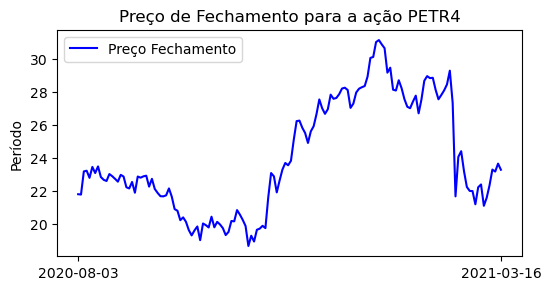

In [11]:
ds_petr4 = read_csv('PETR4.SA.csv', usecols=['Date','Adj Close'], header=0, index_col='Date')
ds_petr4 = ds_petr4.dropna()

exibe_grafico_com_preco_fechamento(ds_petr4, 'Preço de Fechamento para a ação PETR4')

### Criação dos datasets de Treino e Teste

In [12]:
ds_petr4 = ds_petr4.astype('float32')

ds_petr4_sc = sc.fit_transform(ds_petr4)

num_time_frames_petr4 = 5

X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
    num_time_frames_petr4, num_features_petr4, num_obs_petr4 = \
    cria_dataset_treino_teste(ds_petr4_sc, num_time_frames_petr4)

### Previsão usando o modelo LSTM

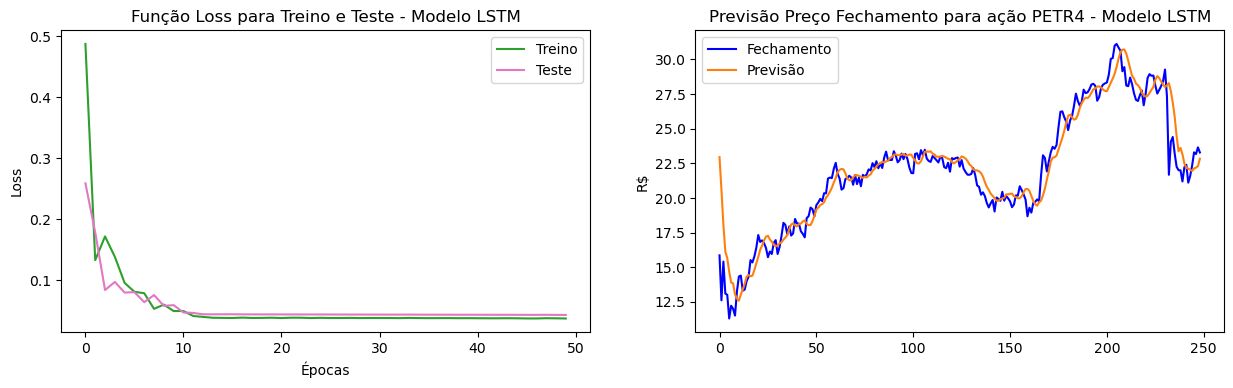

Teste MSE - Modelo LSTM: 1.645


In [13]:
historico_lstm, teste_lstm_inv, previsao_lstm_inv = \
    processa_modelo('LSTM', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_lstm, \
                 teste_lstm_inv, \
                 previsao_lstm_inv, \
                 'Função Loss para Treino e Teste - Modelo LSTM', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo LSTM', \
                 'Teste MSE - Modelo LSTM:')

### Previsão usando o modelo RNN

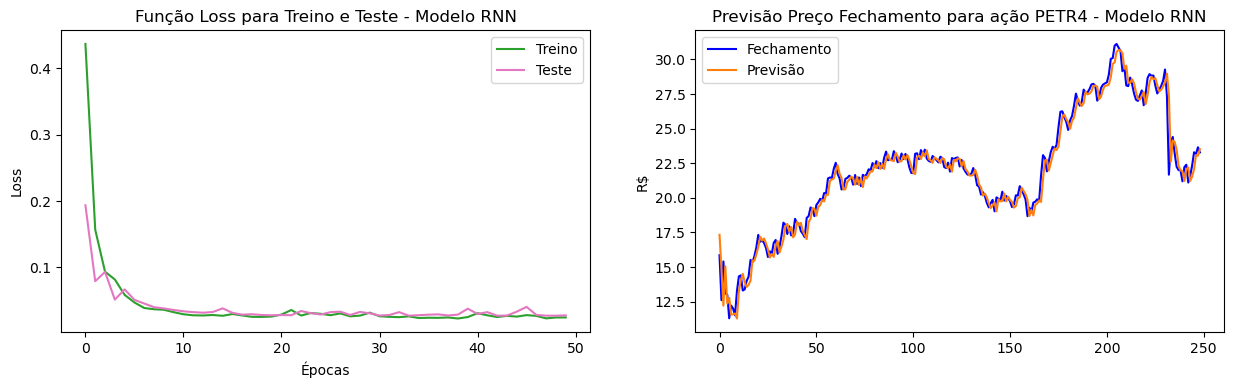

Teste MSE - Modelo RNN: 0.619


In [14]:
historico_rnn, teste_rnn_inv, previsao_rnn_inv = \
    processa_modelo('RNN', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_rnn, \
                 teste_rnn_inv, \
                 previsao_rnn_inv, \
                 'Função Loss para Treino e Teste - Modelo RNN', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo RNN', \
                 'Teste MSE - Modelo RNN:')

### Previsão usando o modelo GRU

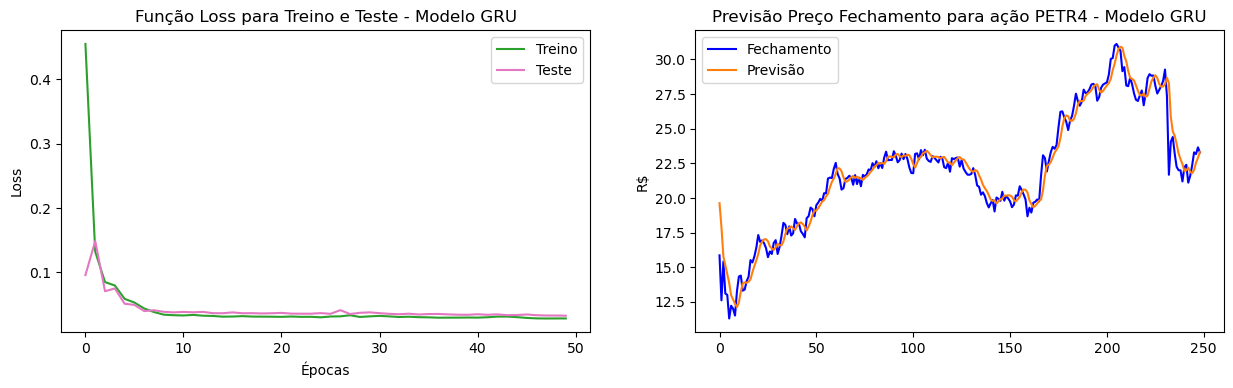

Teste MSE - Modelo GRU: 0.906


In [15]:
historico_gru, teste_gru_inv, previsao_gru_inv = \
    processa_modelo('GRU', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_gru, \
                 teste_gru_inv, \
                 previsao_gru_inv, \
                 'Função Loss para Treino e Teste - Modelo GRU', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo GRU', \
                 'Teste MSE - Modelo GRU:')

## Incluindo Indicadores Técnicos para fazer a previsão

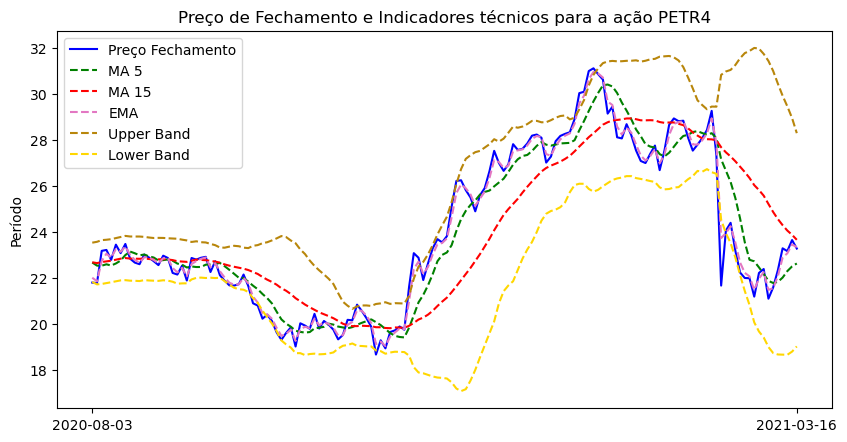

In [16]:
ds_petr4_i = read_csv('PETR4.SA.csv', usecols=['Date','Adj Close'], header=0, index_col='Date')
ds_petr4_i = ds_petr4_i.dropna()

ds_petr4_i = adiciona_indicadores_tecnicos(ds_petr4_i)
ds_petr4_i = ds_petr4_i.dropna()

exibe_grafico_com_indicadores(ds_petr4_i, 'Preço de Fechamento e Indicadores técnicos para a ação PETR4')

### Criação dos datasets de Treino e Teste

In [17]:
ds_petr4_i = ds_petr4_i.astype('float32')

ds_petr4_i_sc = sc.fit_transform(ds_petr4_i)

num_time_frames_petr4_i = 5

X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
    num_time_frames_petr4_i, num_features_petr4_i, num_obs_petr4_i = \
    cria_dataset_treino_teste(ds_petr4_i_sc, num_time_frames_petr4_i)

### Previsão usando o modelo LSTM

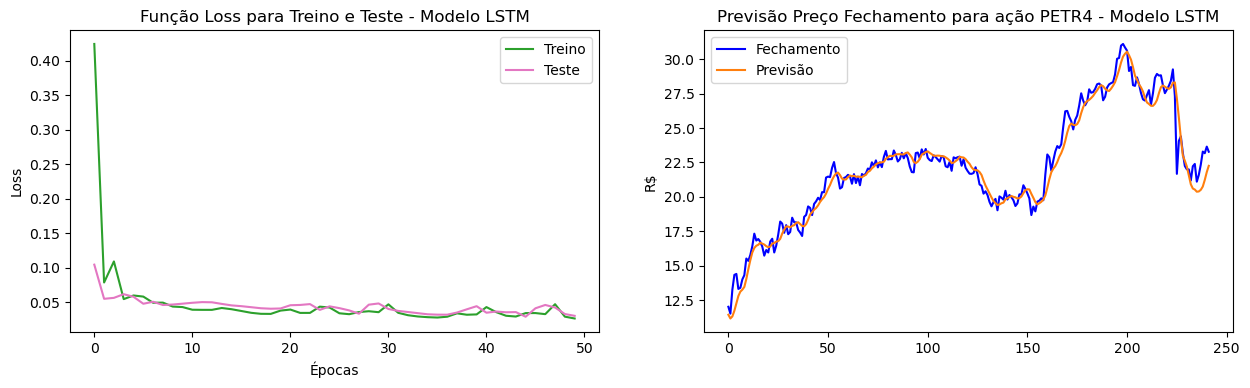

Teste MSE - Modelo LSTM: 0.715


In [18]:
historico_lstm_i, teste_lstm_inv_i, previsao_lstm_inv_i = \
    processa_modelo('LSTM', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_lstm_i, \
                 teste_lstm_inv_i, \
                 previsao_lstm_inv_i, \
                 'Função Loss para Treino e Teste - Modelo LSTM', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo LSTM', \
                 'Teste MSE - Modelo LSTM:')

### Previsão usando o modelo RNN

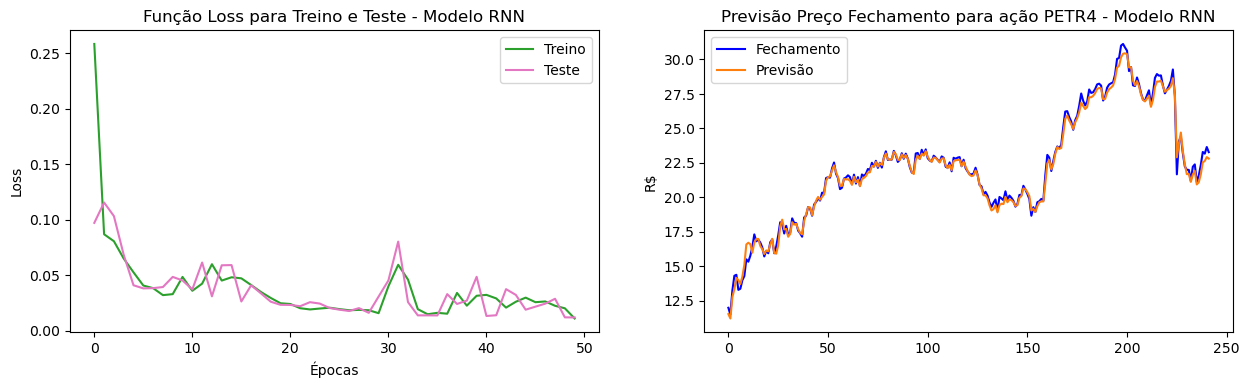

Teste MSE - Modelo RNN: 0.106


In [19]:
historico_rnn_i, teste_rnn_inv_i, previsao_rnn_inv_i = \
    processa_modelo('RNN', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_rnn_i, \
                 teste_rnn_inv_i, \
                 previsao_rnn_inv_i, \
                 'Função Loss para Treino e Teste - Modelo RNN', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo RNN', \
                 'Teste MSE - Modelo RNN:')

### Previsão usando o modelo GRU

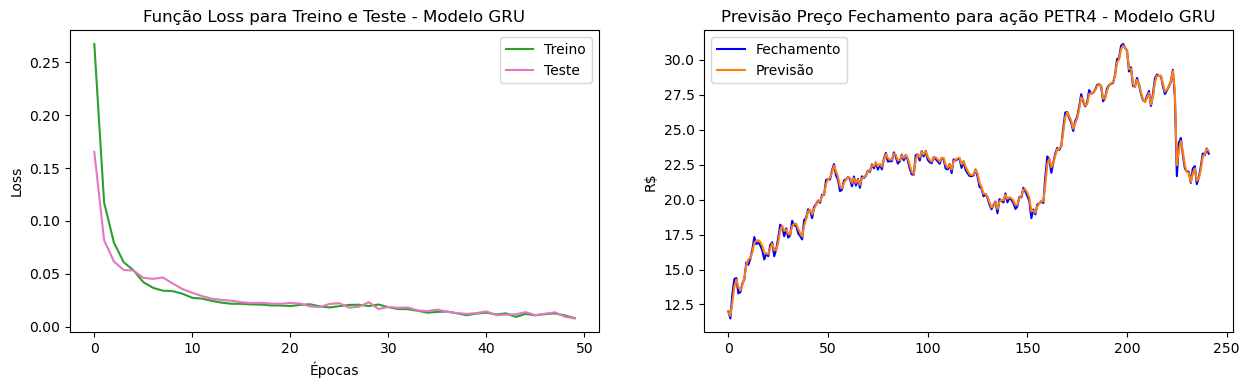

Teste MSE - Modelo GRU: 0.040


In [20]:
historico_gru_i, teste_gru_inv_i, previsao_gru_inv_i = \
    processa_modelo('GRU', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_gru_i, \
                 teste_gru_inv_i, \
                 previsao_gru_inv_i, \
                 'Função Loss para Treino e Teste - Modelo GRU', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo GRU', \
                 'Teste MSE - Modelo GRU:')